# Fake News: Detección de noticias falsas 

> **Objetivo**: 
Identificación de noticias falsas mediante procesamiento del lenguaje 

### Librerias

In [1]:
import pandas as pd
import numpy as np
import re 

In [2]:
data = pd.read_csv("D:/DATASET/news.csv")
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Dividir en Train-Test

In [289]:
X = data[["title","text"]]
Y = data.label

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Pre procesado de texto

### Función procesar texto: 

Mediante la siguiente función eliminamos stop words, elementos extraños y devolvemos las palabras en sus lemmas y lower. 

In [40]:
import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords 
stop_words = stopwords.words("spanish")

def procesar_frase(frase):
    
    #------------------------------------------------------------------------------------------------ 
    # Eliminar carácteres extraños 
    
    eliminar_caracteres = ["@","#","htt"]
    for caracter in eliminar_caracteres:
        frase = re.sub(f'{caracter}\S+', '', frase)
    #------------------------------------------------------------------------------------------------   
    # Devolver lemmas en lower    
        
    tokens= [token.lemma_.lower() for token in nlp(frase)]        
    
    #Tokens sin stop_words
    tokens = [token for token in tokens if not token in stop_words]
    
    frase = ' '.join(tokens)
    
    frase_procesada = " ".join(frase.split())

    return frase_procesada


In [181]:
X_train_title = X_train.title.apply(procesar_frase)

## Bag of words: CountVectorizer

> Se convierte cada palabra en una columna, añadiendo un 1 si se encuentra la palabra en un determinado corpus o un 0 si no.

In [182]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = X_train_title
vect = CountVectorizer()
matriz = vect.fit_transform(corpus)
bag_words = pd.DataFrame(matriz.toarray(), columns = vect.get_feature_names())
bag_words

,00,000,00pm,01,04,05,06,08,10,100,...,zone,ztech,zuckerberg,zuesse,zulu,вам,праздником,ребята,спасибо,القادمون
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5063,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Random Forest Feature Selection:

Para seleccionar las palabras más utiles y que mejor permiten predecir la variable criterio, aplicaré un Random forest para extraer las variables más usadas y con mayor importancia dentro del modelo: 

In [183]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def best_features (X,Y):
    clf = ExtraTreesClassifier(n_estimators=100)
    clf = clf.fit(X, Y)
    clf.feature_importances_ 
    
    model = SelectFromModel(clf, prefit=True)
    feature_idx = model.get_support()
    feature_name = X.columns[feature_idx]
    X_best = model.transform(X)
    X_best = pd.DataFrame(X_best, columns= feature_name)
    
    print(X.shape[1], X_best.shape[1])
    
    return X_best

In [184]:
X_best = best_features(bag_words,Y_train)

7750 1369


Se produce una selección de características de 1369 (De 7750 que había)

### Aplicar preprocesado a X_test:

In [196]:
#Procesar texto: 
X_procesado = X_test.title.apply(procesar_frase)
    
#Aplicar countvectorizer custom: 
vector = CountVectorizer()
    
matriz_custom = vector.fit(X_best)   #Usar X_best como partida
matriz =  vector.transform(X_test.title)   # Aplicar a X_test

X_test_title = pd.DataFrame(matriz.toarray(), columns = vector.get_feature_names())
X_test_title

,000,10,100,106,11,12,16,18,20,200,...,would,wrong,wrongful,ww3,year,yemen,yes,yet,york,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1263,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest: Clasificación

In [240]:
from sklearn.ensemble import RandomForestClassifier
#.......................................................................
model = RandomForestClassifier(n_estimators=100 ) 
model.fit(X_best, Y_train)
Y_pred_title = model.predict(X_test_title)



from sklearn.metrics import accuracy_score
score=accuracy_score(Y_test,Y_pred_title)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 79.08%


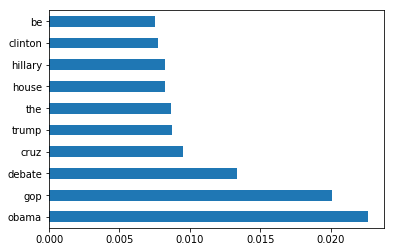

In [198]:
#Importancia de cada variable 
feat_importances = pd.Series(model.feature_importances_, index=X_best.columns)
feat_importances.nlargest(10).plot(kind='barh');

Unicamente conociendo el titulo se puede predecir con un Accuracy entorno al 80% si la noticia será falsa o no. 

¿Qué palabras son las más usadas en un texto falso? 

In [148]:
data_words = X_best.join(Y_train)

top_words = data_words.groupby(['label']).sum().T
top_words["dif"] = abs(top_words["FAKE"]-top_words["REAL"])
top_words.sort_values(by="dif", ascending=False).head(20)

label,FAKE,REAL,dif
in,423,516,93
be,637,546,91
to,700,651,49
trump,420,459,39
clinton,314,278,36
at,81,114,33
hillary,228,258,30
video,68,93,25
vote,57,33,24
with,116,139,23


Aquí se muestran las palabras más usadas en cada una de las noticias clasificadas como Fake/Real y la diferencia de uso en unas u otras. Así por ejemplo noticias que tengan en su titulo "be" y derivados (is,was...)("is Donald Trump...?") tienden a ser más falsas que verdaderas. 

Mientras que otras noticias que usan vocabulario como "kill" o "video" tienden más a ser ciertas

##  TfidfVectorizer

Una vez hecho un bag of words con el titulo y buscado las palabras que mejor permiten predecir si la noticia es falsa o verdadera se obtiene un Accuracy de entorno al 80%, no está mal. No obstante también se posee la información del texto de la noticia en el dataset para lo cual se puede usar un TfidVectorizer, ¿Qué es? 

> TF-IDF es las contracción de: term frequency – inverse document frequency:
Esto se basa en un modelo muy simple:

- Wt,d = TFt,d log (N/DFt)

Para un término (t) en un documento (d),  la importancia del termino (wt) viene determinada por: 

- TFt: Numero de veces que aparece el término t en el documento d (frecuencia)

- DFt: Numero de documentos que contienen el término t 

- N: numero de documentos que se evalúan


> La ecuación indica lo siguiente: la importancia de t (wt) aumenta a medida que aumenta el numero de veces que aparece en el documento, pero desciende drásticamente si ese mismo término aparece también en otros documentos. En otras palabras: Un término es mas importante cuando aparece muchas veces en un documento y pocas veces en todos (el conjunto) los documentos. 

In [305]:
from sklearn.feature_extraction.text import TfidfVectorizer
TF=TfidfVectorizer(stop_words='english', max_df=0.7, max_features=1200)       #Realizar un filtro con stop_words

#Aplicar TF al conjunto y obtener cada columna con el nombre de la palabra a la que refiere 
TF_train=TF.fit_transform(X_train.text) 
TF_train = pd.DataFrame(TF_train.toarray(), columns = TF.get_feature_names())

#Aplicar el mismo filtro al conjunto test 
TF_test=TF.transform(X_test.text)
TF_test = pd.DataFrame(TF_test.toarray(), columns = TF.get_feature_names())

> Probar nuevamente un Random forest con el Tf (En lugar del bag of words)

In [306]:
from sklearn.ensemble import RandomForestClassifier
#.......................................................................
model = RandomForestClassifier(n_estimators=100 ) 
model.fit(TF_train, Y_train)
Y_pred_text = model.predict(TF_test)



from sklearn.metrics import accuracy_score
score=accuracy_score(Y_test,Y_pred_text)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 90.77%


Un 90% de predicción gracias a usar el texto, bueno, TF es un modelo más avanzado y el texto posee mucha mas información que el titulo, nada a extrañar.